In [450]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [534]:
def extract_date(df, date_col):
    df.copy(deep=True)
    df['hour'] = df[date_col].dt.hour
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['day'] = df[date_col].dt.dayofyear
    return df 

### PJM Historical Load Forecasts
From https://dataminer2.pjm.com/feed/load_frcstd_hist

In [457]:
# PJM Load Forecasts
pjm_df = pd.concat(map(pd.read_csv, ['load_forecasts/pjm/2016.csv', 'load_forecasts/pjm/2017.csv','load_forecasts/pjm/2018.csv']))
pjm_df = pjm_df.drop(['evaluated_at_utc', 'evaluated_at_ept', 'forecast_hour_beginning_ept'], axis = 1)
pjm_df.columns = ['Date', 'area', 'PJM']

In [458]:
# RTO columns represent the load forecast for all of PJM
pjm_df = pjm_df.loc[pjm_df['area'] == 'RTO']

In [459]:
# There are multiple forecasts provided per hour so start by averaging them  
pjm_df = pjm_df.groupby( ['Date'] ).mean().reset_index()

In [460]:
pjm_df['Date'] = pd.to_datetime(pjm_df['Date'])
pjm_df = extract_date(pjm_df, 'Date') 

pjm_df = pjm_df.sort_values(by=['year', 'month', 'day', 'hour'])
pjm_df = pjm_df.set_index(['year', 'month', 'day', 'hour'])

pjm_df = pjm_df.drop(['Date'], axis = 1)

In [461]:
# Get solar, wind, hydro together 
pjm_df

PJM  week
year month day hour                    
2016 1     1   5     77462.666667    53
               6     75407.000000    53
               7     73819.666667    53
               8     73057.000000    53
               9     73425.333333    53
...                           ...   ...
2019 1     1   0     98990.444444     1
               1     96469.555556     1
               2     92798.666667     1
               3     86938.700000     1
               4     81641.900000     1

[26304 rows x 2 columns]

### Get Predictions: Hydro, Nuclear, Solar, and Wind

In [484]:
# Load predictions into a DF
solar_wind_hydro_forecast = pd.read_csv('solar_wind_hydro_forecast.csv')

In [485]:
solar_wind_hydro_forecast = solar_wind_hydro_forecast.melt(id_vars=['year', 'month', 'day'], var_name='hour', value_name="mw") 


In [486]:
combined = solar_wind_hydro_forecast.set_index(['year', 'month', 'day', 'hour'])

In [487]:
# Add a week column to merge with nuclear values 
combined = combined.reset_index()
combined['datetime'] = pd.to_datetime(combined['year'] * 1000 + combined['day'], format='%Y%j')

combined['week'] = combined['datetime'].dt.week

In [493]:
nuclear = pd.read_csv('Predictions/nuclear_weekly_average.csv', usecols=[1, 2, 3])

In [494]:
nuclear.columns = ['year', 'week', 'nuclear']

In [496]:
combined = combined.merge(nuclear, how='inner', on=['year', 'week'])

In [497]:
combined = combined.drop(['datetime', 'week'], axis = 1)
combined = combined.sort_values(by=['year', 'month', 'day', 'hour'])
combined = combined.set_index(['year', 'month', 'day', 'hour'])

### Get Fossil Forecasts
Fossil Forecast = Load Forecast - Hydro & Wind & Solar - Nuclear

In [512]:
combined.reset_index(inplace=True)
combined['hour'] = combined['hour'].astype(np.int64)
combined.set_index(['year', 'month', 'day', 'hour'], inplace=True)

In [518]:
fossil_gen = combined.merge(pjm_df, how='inner', left_index=True, right_index=True)

In [519]:
fossil_gen

mw       nuclear      PJM  week
year month day hour                                        
2017 10    281 9     2595.5127  30367.610714  67308.3    40
     9     244 15    3927.8190  33988.070833  88874.3    35
           256 2     1981.7397  32130.327381  81589.1    37
     10    294 6     3339.2075  30492.617857  61645.6    42
     9     248 6     2773.2424  34071.026786  69392.4    36
...                        ...           ...      ...   ...
     10    276 22    6210.9287  30367.610714  93360.6    40
     11    308 3     3179.5830  30796.228571  72103.4    44
     12    343 20    4181.5420  35360.439881  95444.5    49
     11    323 5     6087.1310  33320.060714  71236.3    46
     12    339 3     7748.7725  35360.439881  86800.6    49

[2904 rows x 4 columns]

In [520]:
# Add net import with PJM 
fossil_gen['fossil gen'] = fossil_gen['PJM'] - fossil_gen['mw'] - fossil_gen['nuclear'] 


In [546]:
fossil_gen.to_csv('fossil_gen_for_simple_dispatch_v2.csv')

### Compare Weekly, Monthly, and Hourly Average

### Compare to Fossil Generation (Coal, Gas, Multiple Fuels, Oil)

In [540]:
actual_gen = pd.concat(map(pd.read_csv, ['actual_gen2016.csv', 'actual_gen2017.csv']))

In [541]:
fossil_fuel_type = ['Coal', 'Gas', 'Multiple Fuels', 'Oil']
actual_gen = actual_gen.loc[actual_gen['fuel_type'].isin(fossil_fuel_type)]

In [542]:
actual_gen = actual_gen.drop(['datetime_beginning_ept', 'fuel_type', 'fuel_percentage_of_total', 'is_renewable'], axis = 1)
actual_gen = actual_gen.groupby( ['datetime_beginning_utc'] ).sum().reset_index()
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])

In [543]:
actual_gen = extract_date(actual_gen, 'datetime_beginning_utc')
actual_gen = actual_gen.drop(['datetime_beginning_utc'], axis=1)
actual_gen = actual_gen.sort_values(by=['year', 'month','day', 'hour'])


In [544]:
actual_gen = actual_gen.set_index(['year', 'month', 'day', 'hour'])

In [545]:
actual_gen

mw
year month day hour         
2016 1     1   5     19872.0
               6     19411.6
               7     19168.0
               8     18772.4
               9     18692.7
...                      ...
2018 1     1   1     78532.5
               2     77007.9
               3     75789.2
               4     74259.3
               5     73466.6

[17395 rows x 1 columns]

In [548]:
fossil_gen = fossil_gen[['fossil gen']]

In [550]:
compare = fossil_gen.merge(actual_gen, how='inner', left_index=True, right_index=True)


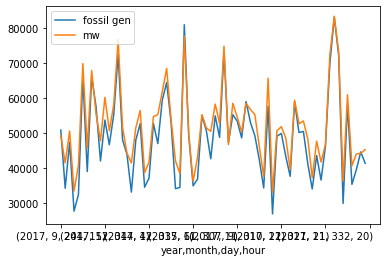

In [555]:
compare.head(70).plot()

In [556]:
compare

fossil gen       mw
year month day hour                       
2017 9     244 15    50958.410167  49356.5
     10    281 9     34345.176586  41554.5
     9     256 2     47477.032919  50696.4
     10    294 6     27813.774643  33532.9
     9     248 6     32548.130814  40952.8
...                           ...      ...
     10    276 22    56782.060586  58647.9
     11    308 3     38127.588429  40773.7
     12    343 20    55902.518119  61410.8
     11    323 5     31829.108286  36096.5
     12    339 3     43691.387619  46251.5

[2904 rows x 2 columns]

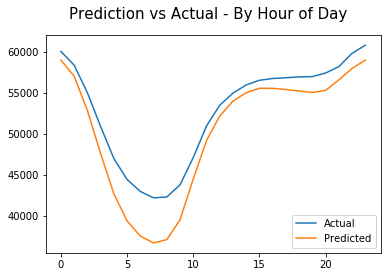

In [557]:
# Find hourly average 
predicted_hourly = compare['fossil gen'].groupby( ['hour'] ).mean().reset_index()
actual_hourly = compare['mw'].groupby(['hour']).mean().reset_index()

plt.suptitle('Prediction vs Actual - By Hour of Day', fontsize=15)
plt.plot(actual_hourly['mw'], label='Actual')
plt.plot(predicted_hourly['fossil gen'], label='Predicted')
plt.legend()

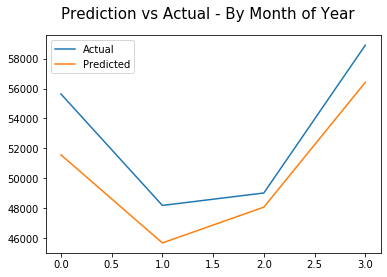

In [559]:
# Find monthly average 
predicted_monthly = compare['fossil gen'].groupby( ['month'] ).mean().reset_index()
actual_monthly = compare['mw'].groupby(['month']).mean().reset_index()

plt.suptitle('Prediction vs Actual - By Month of Year', fontsize=15)
plt.plot(actual_monthly['mw'], label='Actual')
plt.plot(predicted_monthly['fossil gen'], label='Predicted')
plt.legend()